## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [4]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
len(df['user_id'].unique())

290584

d. The proportion of users converted.

In [7]:
p = df['converted'].mean()
p


0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
df2 = df.query("(group == 'control' and landing_page == 'new_page') or (group == 'treatment' and landing_page == 'old_page')") 
df2.shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [11]:
# Double Check all of the correct rows were removed - this should be 0 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2.duplicated(['user_id'])]['user_id'].unique()

array([773192], dtype=int64)

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop_duplicates(['user_id'], keep='first')

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
len(df2.query("landing_page == 'new_page'")) / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

#### Evidence that one page leads to more conversions?

-Given that an individual was in the treatment group, the probability they converted is 0.118807
-Given that an individual was in the control group, the probability they converted is 0.120386
-The old page does better, but by a very tiny margin.
-Probability that an individual recieved a new page is roughly 0.5, this means that it is not possible for there to be a difference in conversion based on being given more opportunities to do so.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Hypothesis

##### H0: Pold >= Pnew
##### H1: Pold< Pnew

#### In other words

##### H0: Pnew <= Pold
##### H1: Pnew > Pold


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = len(df2.query("group == 'treatment'"))
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = len(df2.query("group == 'control'"))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted

array([0, 0, 0, ..., 0, 0, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted =  np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
diff=new_page_converted.mean()-old_page_converted.mean()
diff

-0.0016125185712276419

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  14.,  109.,  531., 1715., 2900., 2790., 1493.,  374.,   66.,
           8.]),
 array([-4.64097105e-03, -3.69664940e-03, -2.75232776e-03, -1.80800611e-03,
        -8.63684463e-04,  8.06371840e-05,  1.02495883e-03,  1.96928048e-03,
         2.91360213e-03,  3.85792377e-03,  4.80224542e-03]),
 <a list of 10 Patch objects>)

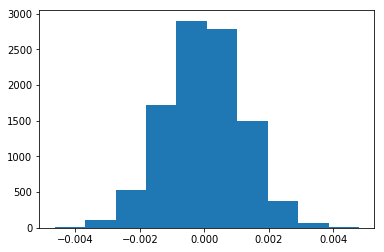

In [30]:
plt.hist(p_diffs)


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
act_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
print(act_diff)
p_diffs = np.array(p_diffs)
(act_diff < p_diffs).mean()

-0.0015782389853555567


0.9059

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This is P-value.
which suggests if there is a significant difference between 2 groups for a hypothesis. In this case, the new page doesn't have better conversion rates than the old page because the value 0.9 is much higher than the alpha, 0.05.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page" and converted==1').count()[0]
convert_new = df2.query('landing_page=="new_page" and converted==1').count()[0]
n_old = df2.query('landing_page=="old_page"').count()[0]
n_new = df2.query('landing_page=="new_page"').count()[0]
print(convert_old)
print(n_old)
print(convert_new)
print(n_new)

17489
145274
17264
145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new,n_old], alternative='larger')
print(p_value)
print(z_score)

0.9050583127590245
-1.3109241984234394


In [34]:
from scipy.stats import norm

print(norm.cdf(z_score))
# Tells us how significant our z-score is

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))
# Tells us what our critical value at 95% confidence is 
# Here, we take the 95% values as specified in PartII.1

0.09494168724097551
1.6448536269514722


Since the z-score of 1.31 less than the critical value of 1.64, we fail to reject the null hypothesis which suggest the new page conversion rate is higher than the old rate. Since they are different,And Yes I Agree with findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept'] = 1
df2[['control','treatment']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
import statsmodels.api as sm

logit = sm.Logit(df2['converted'],df2[['intercept' ,'treatment']])
results = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        10:45:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value here suggests that new page is not statistically significant as 0.19 > 0.05. The values are different because in part 2 we randomly sampled the data 10000 times and the sample could have overlapped or been mutually exclusive to an extent to give different values such that differet p-values were received than what we got in logistic regression.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Considering other factors/explanatory variables makes our hypothesis results more reliable as it can improve the r-sqaured values plus we might miss other influencing factors of out response variables. But if multicolinearity exists, that is correlation between explanatory variables then our results will be wrong. So we need to make sure that there is no multicolinearity.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
df_countries = pd.read_csv('countries.csv')
df_new = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner') #Merging 2 data frames with index as user_id
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [39]:
# Create the necessary dummy variables. 
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,control,treatment,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [40]:
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US']])
results = mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 23 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        10:45:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
# Fit Your Linear Model And Obtain the Results
df['intercept'] = 1

log_mod = sm.Logit(df_new['converted'], df_new[['CA', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.447174
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Sep 2018   Pseudo R-squ.:                 -0.2214
Time:                        10:45:08   Log-Likelihood:            -1.2994e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CA            -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US            -1.9967      0.007   -292.314      0.000      -2.010      -1.983
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions


we find that the values do not show a substantial difference in teh conversion rates for control group and treatment group.
This indicates that we can acceot the Null Hypothesis and keep the existing page as is.
there is no significant impact of the countries and new page on conversion rates.
the performance of the old page was found better than the new page.